### Focus on what matters: inferring low-dimensional dynamics from neural recordings

__By Neuromatch Academy__

__Content creators:__ Marius Pachitariu, Pedram Mouseli, Lucas Tavares, Jonny Coutinho, Blessing Itoro, Gaurang Mahajan, Rishika Mohanta

__Project team (Alphabetical order):__ Ke Chen, Mohammad Samavat, Raymond Shpeley, Dev laxman Subramanian, Arjun Verma, 

__Install to VSCode:__ If you plan to run on a GPU make sure your drivers are installed and working. Follow these directions,

```
    [install WSL if on Windows]()
    [install miniconda]()
    [create a pytorch environment in conda based on GPU or CPU]()
    [activate the environment and install pytorch]()
    [install matplotlib]()
    [install vscode (for WSL if on Windows)]()
    [install vscode extensions for python and jupyter]()
    create development folders such as ~/dev/nma/project,
```
``` bash
    mkdir -p ~/dev/nma/project
```
```
    git init in the project folder,
```
``` bash
    cd ~/dev/nma/project
    git init
```
```
    move this file to the project folder,
```
``` bash
    mv ~/Downloads/"inferring low-dimensional dynamics.ipynb" ~/dev/nma/project
```

__NOTE:__ This notebook was adapted from the [Jupyter Book file](https://deeplearning.neuromatch.io/projects/Neuroscience/neuro_seq_to_seq.html).
___

#### Objective:

It is very difficult to interpret the activity of single neurons in the brain, because their firing patterns are noisy, and it is not clear how a single neuron can contribute to cognition and behavior. However, neurons in the brain participate in local, regional and brainwide dynamics. No neuron is isolated from these dynamics, and much of a single neuron’s activity can be predicted from the dynamics. Furthermore, only populations of neurons as a whole can control cognition and behavior. Hence it is crucial to identify these dynamical patterns and relate them to stimuli or behaviors.

In this notebook, we generate simulated data from a low-dimensional dynamical system and then use seq-to-seq methods to predict one subset of neurons from another. This allows us to identify the low-dimensional dynamics that are sufficient to explain the activity of neurons in the simulation. The methods described in this notebook can be applied to large-scale neural recordings of hundreds to tens of thousands of neurons, such as the ones from the NMA-CN course.
___

### Project objectives:

Learn...

Evaluate...

Document...
___

#### Setup

In [1]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

#### Set torch device as GPU or CPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Simulate some data from a linear dynamical system

In [3]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 400

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0 = .025 * np.random.randn(ncomp, NN)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
latents = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep
for t in range(NT):
  y = y @ A0 +  np.random.randn(ntrials, ncomp)
  latents[t] = y

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x = np.random.poisson(rates)

#### Define RNN

In [4]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

#### Plot and Prepare data

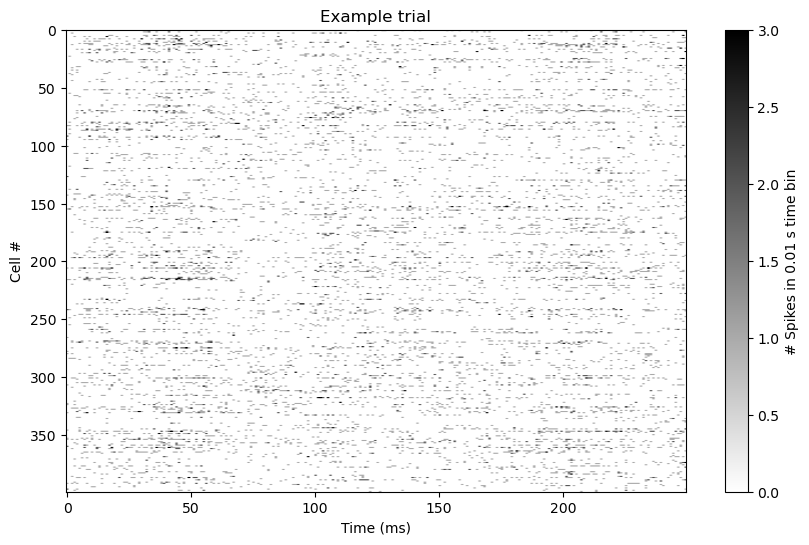

In [6]:
plt.figure(figsize = (10, 6))
plt.imshow(x[:, 0, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

#### Train the RNN: setup

In [5]:
# we separate the neuron data into two populations: the input and output
x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

#### Train the RNN

In [6]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 0.4151
iteration 100, cost 0.2590
iteration 200, cost 0.2455
iteration 300, cost 0.2409
iteration 400, cost 0.2399
iteration 500, cost 0.2378
iteration 600, cost 0.2371
iteration 700, cost 0.2369
iteration 800, cost 0.2370
iteration 900, cost 0.2370


#### Compare true firing rates with the predicted

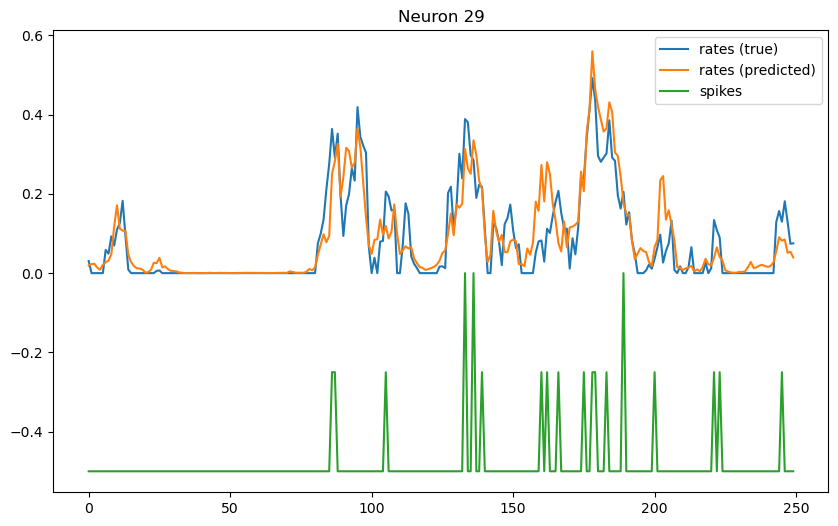

In [7]:
rpred = z.detach().cpu().numpy()

nn = 29
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nn, 0])
plt.plot(rpred[:,nn, 0])
plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

#### View firing rates for all neurons in one trial

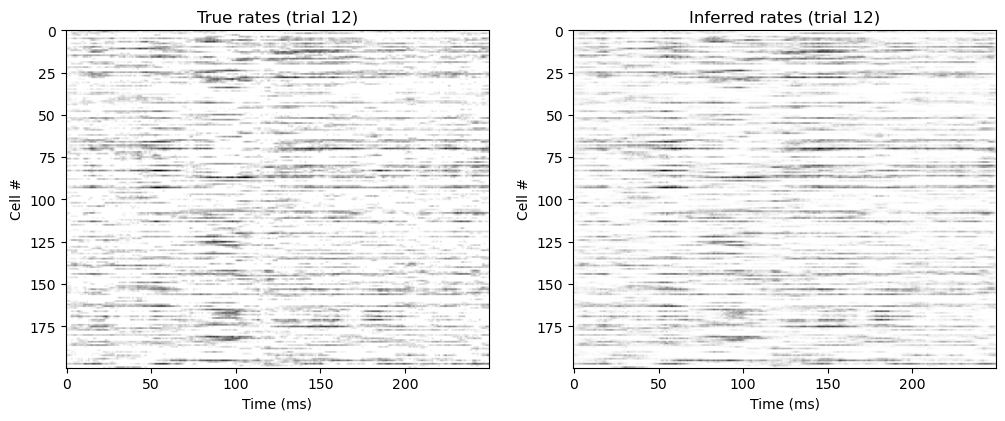

In [8]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, 12, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

#### Visualize the latent dynamics

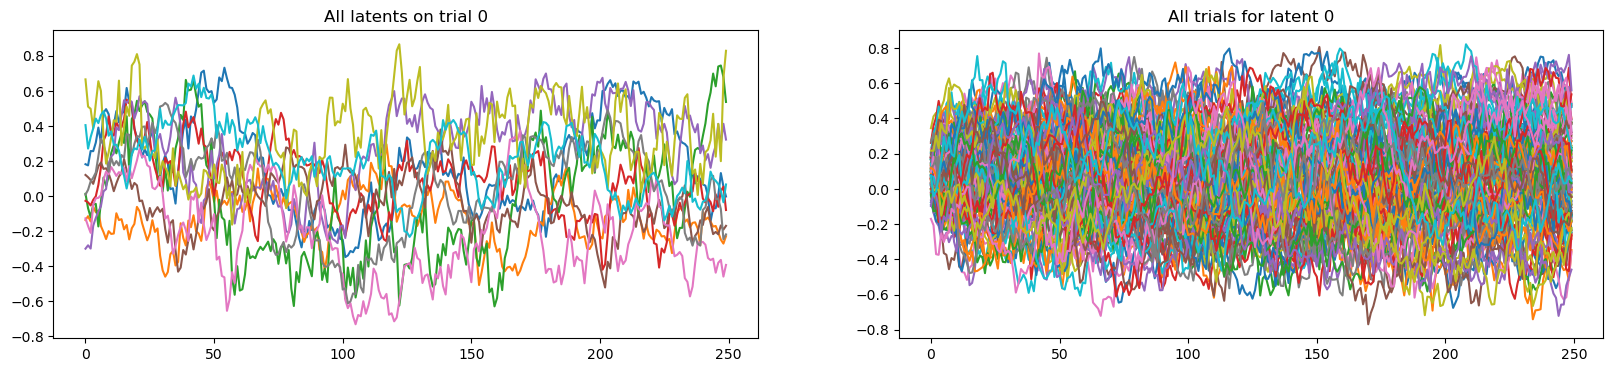

In [9]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()

Not much to see for the latents. This is not surprising, since we generated them with random data, so they look just like a random walk process.

Now apply this model on real data and see if you can interpret the latents.
___

### Project example code analysis
It was crucial for all of us to obtain an understanding of what was going on with the project example. What was the project trying to show? How did the code work, exactly? 

Our team of biological neural researchers, computational neuroscientists, and programmers needed to get on the same page. The following is our team analysis of the project example code and data. We used an essemble approach to combine insights and worked on communicating those effectively. 

We skip initialisation code in this section.
___

#### Neural recordings background
Neural recordings are obtained by inserting a probe with multiple sensors along its length into the brain of a subject. 

![neural probe][probe]

[probe]: https:// "One type of neural probe to record neural activity along its length"

There are many potential issues when generating a neural activity recording: 
1. neural cells die from probe insertion and over time, 
2. neural signals are inherently noisy,
3. all data must be recorded in one session to ensure the same neurons are measured with their particular latent connections,
4. trial data for a given trial type are limited by the duration of the experiment and how many trial types are performed during the experiment,
5. the subject requires rest and rewards, and variations of these affect the data.

The simulated data does not take into account these sources of error, except, potentially noise in the data, but it does generate ground truth for training.
___

#### Visualising variance in the data
In experimental data the time to stimulation, time between stimulation and response, and time after response varies. In a time sequenced network, such as an RNN, these timings will be trained into the network. How can a graph show these timings? and how do these timings influence the error of the network?
___

### Project activities
We needed to dig deeper to make sense of the randomly generated data and project code. To do this we determined the expected experimental procedure to acquire real data and then asked how the generated data compared. 
___

#### Finding and cleaning datasets
Since we can't perform these experiemnts ourselves we're limited by the datasets we find. What we've looked for are datasets with a sufficient number of trials for a given trial type to reduce the effects of noise and potentially to enlist deeper neural networks along with RNNs or other time sequence learning algorithms such as LSTM.

Often data are combined with data from other experiments and we need to extract the data we're interested in. Additionally, we group the data by trial type. 

These are some datasets we're looking into, which you'll find have been tested with various types of training code.
1.
2.
3.
___